In [1]:
pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 6.0 MB/s eta 0:00:0000:01m0:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os  # Only needed if figures or data are saved elsewhere
import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    tensor, basis, qeye, Qobj,
    sigmax, sigmay, sigmaz, sigmam, sigmap,
    bloch_redfield_tensor, liouvillian, steadystate, expect,
    operator_to_vector,   # |ρ⟩⟩ mapping (unused here but imported for completeness)
    vector_to_operator
)
from matplotlib import rc 

In [25]:
import os  # Only needed if figures or data are saved elsewhere
import numpy as np
import matplotlib.pyplot as plt
from qutip import (
    tensor, basis, qeye, Qobj,
    sigmax, sigmay, sigmaz, sigmam, sigmap,
    bloch_redfield_tensor, liouvillian, steadystate, expect,
    operator_to_vector,   # |ρ⟩⟩ mapping (unused here but imported for completeness)
    vector_to_operator
)
from matplotlib import rc  # Global LaTeX rendering control

# -----------------------------------------------------------------------------
#                              Numerical constants
# -----------------------------------------------------------------------------
# Regularisation threshold: whenever |ω| ≤ ε the Bose factor is set to zero to
# avoid a logarithmic divergence.

epsilon = 1e-13

# -----------------------------------------------------------------------------
#                    Two qubit operator algebra (tensor basis)
# -----------------------------------------------------------------------------
# Single qubit Pauli operators embedded in the full four level Hilbert space.
# Example: σ_x^{(1)} ≡ σ_x ⊗ 𝟙, σ_x^{(2)} ≡ 𝟙 ⊗ σ_x.

# Define Pauli operators for each qubit
sx1, sy1, sz1 = (tensor(op, qeye(2)) for op in (sigmax(), sigmay(), sigmaz()))
sx2, sy2, sz2 = (tensor(qeye(2), op) for op in (sigmax(), sigmay(), sigmaz()))
sm1 = tensor(sigmam(), qeye(2))
sp1 = tensor(sigmap(), qeye(2))
sm2 = tensor(qeye(2), sigmam())
sp2 = tensor(qeye(2), sigmap())

# Qubit-Resonator Coupling Asymmetry (as arrays)
g_1 = np.linspace(0.001, 0.009, 50) # Qubit 1 coupling to hot bath
g_2 = np.linspace(0.001, 0.009, 50) # Qubit 2 coupling to hot bath
g_3 = g_1
g_4 = g_2

c_t1 = np.zeros((50, 50)) # to store cos(theta_1)
s_t1 = np.zeros((50, 50)) # to store sin(theta_1)
c_t2 = np.zeros((50, 50)) 
s_t2 = np.zeros((50, 50))

Jm_list = np.empty((50, 50), dtype=object) # to store J_- operators for different g_1 and g_2, 
                                           #essentially using Eq. 4 from the additional notes written by Marcello
Jp_list = np.empty((50, 50), dtype=object) # to store J_+ operators for different g_1 and g_2
sx1_list = np.empty((50, 50), dtype=object) # substituting Eq.4 into J_x = J_+ + J_- to get a new collective resonator operator
#sx2_list = np.empty((50, 50), dtype=object)

for i, g1 in enumerate(g_1):
    for j, g2 in enumerate(g_2):
        # Mixing angles as arrays
        c_t1[i, j] = g_1[i] / np.sqrt((g_1[i])**2 + (g_2[j])**2)
        s_t1[i, j] = g_2[j] / np.sqrt((g_1[i])**2 + (g_2[j])**2)
        c_t2[i, j] = g_3[i] / np.sqrt((g_3[i])**2 + (g_4[j])**2)
        s_t2[i, j] = g_4[j] / np.sqrt((g_3[i])**2 + (g_4[j])**2)

        # Compute collective operators Jm and Jp at each point
        Jm_list[i,j] = np.sqrt(2) * (c_t1[i,j] * sm1 + s_t1[i,j] * sm2) 
        Jp_list[i,j] = np.sqrt(2) * (c_t1[i,j] * sp1 + s_t1[i,j] * sp2) 
        sx1_list[i, j] = np.sqrt(2) * (c_t1[i,j] * sx1 + s_t1[i,j] * sx2) 
        #sx2_list[i, j] = np.sqrt(2) * (c_t2[i,j] * sx1 + s_t2[i,j] * sx2) 


# -----------------------------------------------------------------------------
#                    Thermal occupation and effective temperature
# -----------------------------------------------------------------------------

def nB(omega: float, T: float) -> float:
    """Bose–Einstein occupation n_B(ω, T) with overflow protection."""
    if abs(omega) <= epsilon:
        return 0.0
    beta = 1.0 / T
    if beta * abs(omega) > 700:  # exp(700) is close to float overflow
        return 0.0
    return 1.0 / (np.exp(beta * omega) - 1.0)


def T_star(T_c: float, gamma_c: float, T_h: float, gamma_h: float, w0: float) -> float:
    """Effective temperature of the composite resonator bath."""
    den = (
        (nB(w0, T_h) + 1) * gamma_h + (nB(w0, T_c) + 1) * gamma_c
    ) / (
        nB(w0, T_h) * gamma_h + nB(w0, T_c) * gamma_c
    )
    return w0 / np.log(den)

# -----------------------------------------------------------------------------
#                       Bath spectral densities (Lorentzian)
# -----------------------------------------------------------------------------
# Each bath spectrum J(ω) is formed by a Bose factor times a Lorentzian filter
# centred at the resonator frequency w0 with quality factor Q1.


def J_h(w: float, T_h: float, gamma_h: float, w0: float, Q1: float) -> float:
    """Hot bath spectrum J_h(ω)."""
    w_abs = np.abs(w)
    nb = nB(w_abs, T_h)
    lam = w0 / Q1  # Full width at half maximum Γ = ω0 / Q
    Lor = (0.5 * lam) / ((w_abs - w0) ** 2 + (0.5 * lam) ** 2)
    return (
        gamma_h * (1.0 + nb) * (w > epsilon) +
        gamma_h * nb * (w < -epsilon)
    ) * Lor


def J_c(w: float, T_c: float, gamma_c: float, w0: float, Q1: float) -> float:
    """Cold bath spectrum J_c(ω)."""
    w_abs = np.abs(w)
    nb = nB(w_abs, T_c)
    lam = w0 / Q1
    Lor = (0.5 * lam) / ((w_abs - w0) ** 2 + (0.5 * lam) ** 2)
    return (
        gamma_c * (1.0 + nb) * (w > epsilon) +
        gamma_c * nb * (w < -epsilon)
    ) * Lor


def J_global(w: float, T_c: float, gamma_c: float, T_h: float, gamma_h: float,
             w0: float, Q1: float) -> float:
    """Composite spectrum J_global(ω) = J_c + J_h."""
    return J_c(w, T_c, gamma_c, w0, Q1) + J_h(w, T_h, gamma_h, w0, Q1)

# -----------------------------------------------------------------------------
#                            Heat current estimators
# -----------------------------------------------------------------------------
# *Current_ind* computes the heat current into the hot bath when each qubit
# couples independently.  *Current_coll* does the same for collective coupling.

#Current_ind now takes in one additional parameter gamma_h_q2 to take into account that for when g1 ≠ g2
def Current_ind(w1: float, w2: float, rho, T_h: float, gamma_h_q1: float, gamma_h_q2: float,
                w0: float, Q1: float) -> float:
    """Independent coupling heat current for a given steady state ρ."""
    # Transition rates for each qubit
    rate_sm1 = J_h(+w1, T_h, gamma_h_q1, w0, Q1)
    rate_sp1 = J_h(-w1, T_h, gamma_h_q1, w0, Q1)
    rate_sm2 = J_h(+w2, T_h, gamma_h_q2, w0, Q1)
    rate_sp2 = J_h(-w2, T_h, gamma_h_q2, w0, Q1)
    # Two point correlators ⟨σ_± σ_∓⟩
    Sp1Sm1 = expect(sp1 * sm1, rho)
    Sm1Sp1 = expect(sm1 * sp1, rho)
    Sp2Sm2 = expect(sp2 * sm2, rho)
    Sm2Sp2 = expect(sm2 * sp2, rho)
    # Energy balance
    Q_dot  = w1 * (-rate_sm1 * Sp1Sm1 + rate_sp1 * Sm1Sp1)
    Q_dot += w2 * (-rate_sm2 * Sp2Sm2 + rate_sp2 * Sm2Sp2)
    return Q_dot

'''
def Current_coll(w1: float, w2: float, rho, T_h: float, gamma_h_q1: float, gamma_h_q2: float,
                 w0: float, Q1: float) -> float:
    """Collective coupling heat current for a given steady state ρ."""
    Q_dot = 0.0
    if w1 == w2:  # Degenerate qubits ⇒ collective J_± jumps only
        En = np.array([w1, -w1])
        S = [Jm, Jp]
        for i in range(2):
            for j in range(2):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    else:  # Non degenerate case: revert to individual σ_± operators
        En = np.array([w1, w2, -w1, -w2])
        S = [sm1, sm2, sp1, sp2]
        for i in range(4):
            for j in range(4):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    return Q_dot
'''
# Current_coll now takes in two additional parameters J_-^(h) and J_+^(h) instead of calling them inside the function
def Current_coll_2(w1: float, w2: float, rho, T_h: float, gamma_h:float,
                 w0: float, Q1: float, Jm_h: Qobj, Jp_h: Qobj) -> float:
    """Collective coupling heat current for a given steady state ρ."""
    Q_dot = 0.0
    if w1 == w2:  # Degenerate qubits ⇒ collective J_± jumps only
        En = np.array([w1, -w1])
        S = [Jm_h, Jp_h]
        for i in range(2):
            for j in range(2):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    else:  # Non degenerate case: revert to individual σ_± operators
        En = np.array([w1, w2, -w1, -w2])
        S = [sm1, sm2, sp1, sp2]
        for i in range(4):
            for j in range(4):
                Q_dot += -J_h(+En[i], T_h, gamma_h, w0, Q1) * En[j] * \
                         expect((S[i].dag() * S[j] + S[j].dag() * S[i]), rho) / 2
    return Q_dot


# -----------------------------------------------------------------------------
#                  Steady state solvers (collective vs independent)
# -----------------------------------------------------------------------------

# the independent density matrix solver now takes in one additional parameter sigma_sum = 0.5*(σ_x^(1) + σ_x^(2)) = J_x

def rho_ss_termic_collective(w1: float, w2: float, gamma_local: float,
                             T_local: float, gamma_deph: float,
                             T_h: float, gamma_h:float,
                             T_c: float, gamma_c:float,
                             w0: float, Q1: float, sigma_sum: Qobj):
    """Steady state with collective resonator coupling."""
    # System Hamiltonian H = ½(ω1 σ_z^{(1)} + ω2 σ_z^{(2)})
    H = 0.5 * (w1 * sz1 + w2 * sz2)
    # Collective system operator that couples to the resonator mode
    #sigma_sum = sx1 + sx2
    a_ops_coll = [[0.5*sigma_sum,
                   lambda w: J_global(w, T_c, gamma_c, T_h, gamma_h, w0, Q1)]]
    R = bloch_redfield_tensor(H, a_ops_coll, fock_basis=True, sec_cutoff=-1)
    # Local Lindblad channels: thermal relaxation plus pure dephasing
    c_ops = [
        np.sqrt(gamma_local * (1 + nB(w1, T_local))) * sm1,
        np.sqrt(gamma_local * nB(w1, T_local))       * sp1,
        np.sqrt(gamma_local * (1 + nB(w2, T_local))) * sm2,
        np.sqrt(gamma_local * nB(w2, T_local))       * sp2,
        np.sqrt(gamma_deph) * sz1,
        np.sqrt(gamma_deph) * sz2,
    ]
    L_full = R + liouvillian(0 * sz1, c_ops)  # No additional Hamiltonian term
    return steadystate(L_full, method='direct')

# Takes in two new parameter gamma_h_q2 and gamma_c_q2 to when g1 ≠ g2, g3 ≠ g4
def rho_ss_termic_indepentend(
    w1, w2,
    gamma_local, T_local, gamma_deph,
    T_h, gamma_h_q1, gamma_h_q2, T_c, gamma_c_q1, gamma_c_q2,
    w0, Q1
):
    """
    Steady state for the *independent-bath* configuration.

    Each qubit feels the composite resonator spectrum J_global(ω) **locally**
    (i.e. as its own Lindblad channel).  In addition, both qubits couple to a
    parasitic thermal bath at T_local and to a pure-dephasing bath with rate
    gamma_deph.
    """
    # Resonator-induced relaxation / absorption rates
    rate_sm1 = J_global(+w1, T_c, gamma_c_q1, T_h, gamma_h_q1, w0, Q1)
    rate_sp1 = J_global(-w1, T_c, gamma_c_q1, T_h, gamma_h_q1, w0, Q1)
    rate_sm2 = J_global(+w2, T_c, gamma_c_q2, T_h, gamma_h_q2, w0, Q1)
    rate_sp2 = J_global(-w2, T_c, gamma_c_q2, T_h, gamma_h_q2, w0, Q1)

    # Full list of collapse operators:
    #   ─ resonator (first four),
    #   ─ parasitic thermalisation (next four),
    #   ─ pure dephasing (last two).
    c_global_local = [
        np.sqrt(rate_sm1) * sm1,
        np.sqrt(rate_sp1) * sp1,
        np.sqrt(rate_sm2) * sm2,
        np.sqrt(rate_sp2) * sp2,
        np.sqrt(gamma_local * (1 + nB(w1, T_local))) * sm1,
        np.sqrt(gamma_local * nB(w1, T_local))       * sp1,
        np.sqrt(gamma_local * (1 + nB(w2, T_local))) * sm2,
        np.sqrt(gamma_local * nB(w2, T_local))       * sp2,
        np.sqrt(gamma_deph) * sz1,
        np.sqrt(gamma_deph) * sz2,
    ]

    # Bare Hamiltonian: non-interacting qubits with splittings w1, w2.
    H = 0.5 * (w1 * sz1 + w2 * sz2)

    # Liouvillian and steady state.
    L_full = liouvillian(H, c_global_local)
    rho_ss = steadystate(L_full, method="direct")
    return rho_ss




# -------------------------------------------------------------------
# Could be thought of almost separate from the main code, mainly to calculate gamma_h and gamma_c for both qubits
# using current circuit paramters
# -------------------------------------------------------------------
h_2 = 6.626e-34
f_r = 5.6e9
C_r = 2.913e-12
Z_0 = 50
hbar = h_2/(2*np.pi)
w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798       # Resonator quality factor
N3 = 50
R_r = 16.4
C_T = 125.94023e-15
e_c = 1.6e-19
E_j_q1 = (27.59e9*h_2)
E_j_q2 = (27.53e9*h_2)
L_J1 = (hbar/(2*e_c))**2 * (1/E_j_q1)
L_J2 = (hbar/(2*e_c))**2 * (1/E_j_q2)
Z_T1 = np.sqrt(L_J1 / C_T)
Z_T2 = np.sqrt(L_J2 / C_T)

C_c_1 = g_1 * 4 * np.pi * Z_0 * C_T * C_r * f_r
C_c_2 = g_2 * 4 * np.pi * Z_0 * C_T * C_r * f_r

G1 = 2 * (C_c_1 / C_T) * np.sqrt(2 / (hbar * Z_T1))
G2 = 2 * (C_c_2 / C_T) * np.sqrt(2 / (hbar * Z_T2))

# Bath coupling strengths
gamma_h_q1   = (4*h_2*f_r*R_r*G1**2)/f_r   # Qubit 1 coupling to the hot bath using Eq. B19, normalized by resonator frequency
gamma_c_q1  =  gamma_h_q1  # Qubit 1 coupling to the cold bath using Eq. B19, normalized by resonator frequency
gamma_h_q2 = (4*h_2*f_r*R_r*G2**2)/f_r  # Qubit 2 coupling to the hot bath using Eq. B19, normalized by resonator frequency
gamma_c_q2 = gamma_h_q2 # Qubit 2 coupling to the cold bath using Eq. B19, normalized by resonator frequency
gamma_local_2 = 0.001 #0.001   # Parasitic relaxation
gamma_deph_2  = 0.001  # Pure dephasing (σ_z)




# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath
N =50

# Diagnostic: effective temperature of the composite resonator bath


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_3   = np.zeros((N3, N3))   # independent current
Q_coll_3  = np.zeros((N3, N3))  # collective current
Ratio_3  = np.zeros((N3, N3))   # enhancement factor
Lambda_3  = np.zeros((N3, N3))   # minimum eigenvalue (positivity check)
Rho_ind_3 = np.zeros((N3, N3))
Rho_coll_3 = np.zeros((N3, N3)) # to store coherence terms of the density matrix
Ts = np.zeros((N3, N3))

for i, g_h_q1 in enumerate(gamma_h_q1):
    for j, g_h_q2 in enumerate(gamma_h_q2):
        
        coll_g_h = np.sqrt(g_h_q1**2 + g_h_q2**2) # A new collective coupling strength is defined as g_h_coll = sqrt(g_1^2 + g_2^2)
        g_c_q1 = gamma_c_q1[i]
        g_c_q2 = gamma_c_q2[j]
        coll_g_c = np.sqrt(g_c_q1**2 + g_c_q2**2) # Similar to the collective coupling strength of the hot baths
        #Ts[i, j] = T_star(T_c, gamma_c_q1[i], T_h, gamma_h_q1[i], w0)

    # Independent-bath steady state and current
        rho_ind = rho_ss_termic_indepentend(
            1, 1,
            gamma_local_2, T_local, gamma_deph_2,
            T_h, g_h_q1, g_h_q2,  T_c, g_c_q1, g_c_q2, # Note: rho_ind now takes in gamma_h_q1, gamma_h_q2, gamma_c_q1, gamma_c_q2
            w0, Qf
        )
        Rho_ind_3[i, j] = np.real(rho_ind[1][1])
        Q_ind_3[i, j] = Current_ind(1, 1, rho_ind, T_h, g_h_q1, g_h_q2, w0, Qf) # Q_ind now takes in gamma_h_q1, gamma_h_q2

        # Collective-bath steady state and current
        rho_coll = rho_ss_termic_collective(
            1, 1,
            gamma_local_2, T_local, gamma_deph_2,
            T_h, coll_g_h, T_c, coll_g_c,
            w0, Qf, sx1_list[i,j] # now takes in a new J_x for each g_1 and g_2
        )
        Rho_coll_3[i, j] = np.real(rho_coll[1][2])
        Q_coll_3[i, j] = Current_coll_2(1, 1, rho_coll, T_h, coll_g_h, w0, Qf, Jm_list[i, j], Jp_list[i, j]) # Now takes in a new J_- and J_+ for each g_1 and g_2

        # Diagnostics
        Lambda_3[i, j] = np.min(np.linalg.eigvalsh(rho_coll.full()))
        Ratio_3[i, j]  = Q_coll_3[i, j] / Q_ind_3[i, j]

In [50]:
gamma_h_q1

array([0.00159497, 0.00215829, 0.00280664, 0.00354002, 0.00435843,
       0.00526188, 0.00625034, 0.00732384, 0.00848237, 0.00972593,
       0.01105452, 0.01246814, 0.01396679, 0.01555046, 0.01721917,
       0.01897291, 0.02081168, 0.02273547, 0.0247443 , 0.02683815,
       0.02901704, 0.03128095, 0.0336299 , 0.03606387, 0.03858288,
       0.04118691, 0.04387597, 0.04665007, 0.04950919, 0.05245334,
       0.05548252, 0.05859673, 0.06179598, 0.06508025, 0.06844955,
       0.07190388, 0.07544324, 0.07906763, 0.08277705, 0.0865715 ,
       0.09045097, 0.09441548, 0.09846502, 0.10259959, 0.10681919,
       0.11112381, 0.11551347, 0.11998816, 0.12454787, 0.12919262])

In [24]:
np.max(Q_coll_3)-np.max(Q_ind_3)

0.3819194074015506

In [87]:
sx1

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

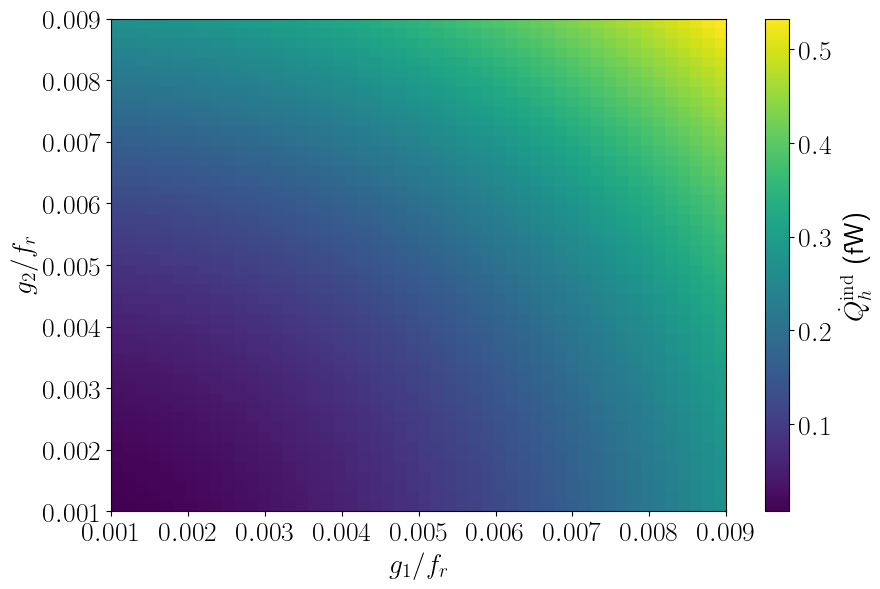

In [26]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*(Q_ind_3), 
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q^{\rm ind}_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

In [97]:
gamma_h_q1

array([0.00159497, 0.00215829, 0.00280664, 0.00354002, 0.00435843,
       0.00526188, 0.00625034, 0.00732384, 0.00848237, 0.00972593,
       0.01105452, 0.01246814, 0.01396679, 0.01555046, 0.01721917,
       0.01897291, 0.02081168, 0.02273547, 0.0247443 , 0.02683815,
       0.02901704, 0.03128095, 0.0336299 , 0.03606387, 0.03858288,
       0.04118691, 0.04387597, 0.04665007, 0.04950919, 0.05245334,
       0.05548252, 0.05859673, 0.06179598, 0.06508025, 0.06844955,
       0.07190388, 0.07544324, 0.07906763, 0.08277705, 0.0865715 ,
       0.09045097, 0.09441548, 0.09846502, 0.10259959, 0.10681919,
       0.11112381, 0.11551347, 0.11998816, 0.12454787, 0.12919262])

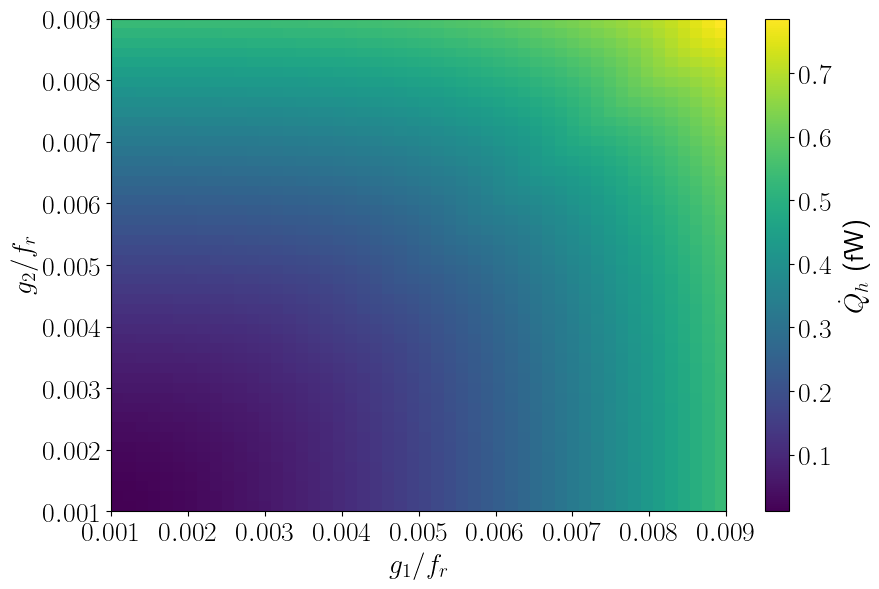

In [27]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    0.662607015*(Q_coll_3),  # negative heat current for display
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()


In [17]:
np.min(Ratio_3)

1.4262606360048111

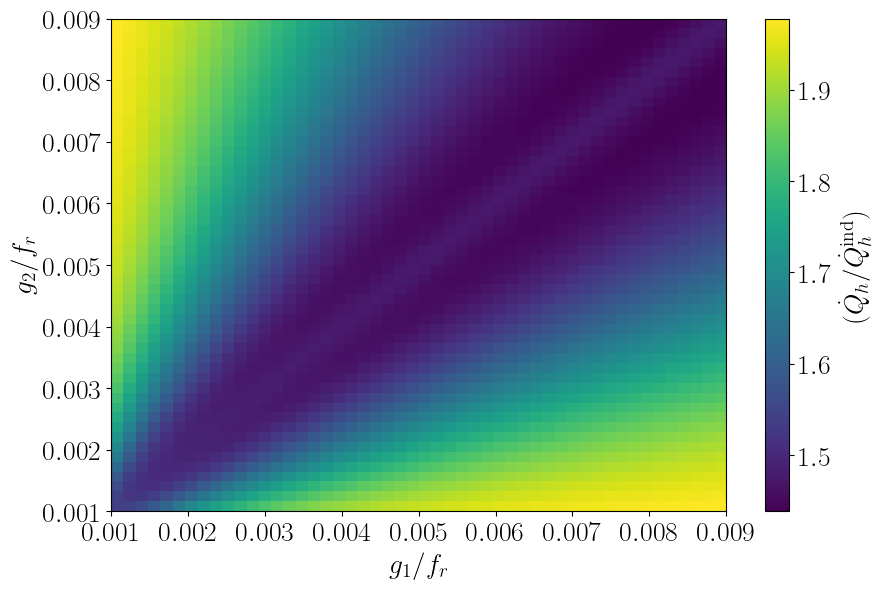

In [28]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio_3,  
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h/\dot Q_h^{\rm ind})$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

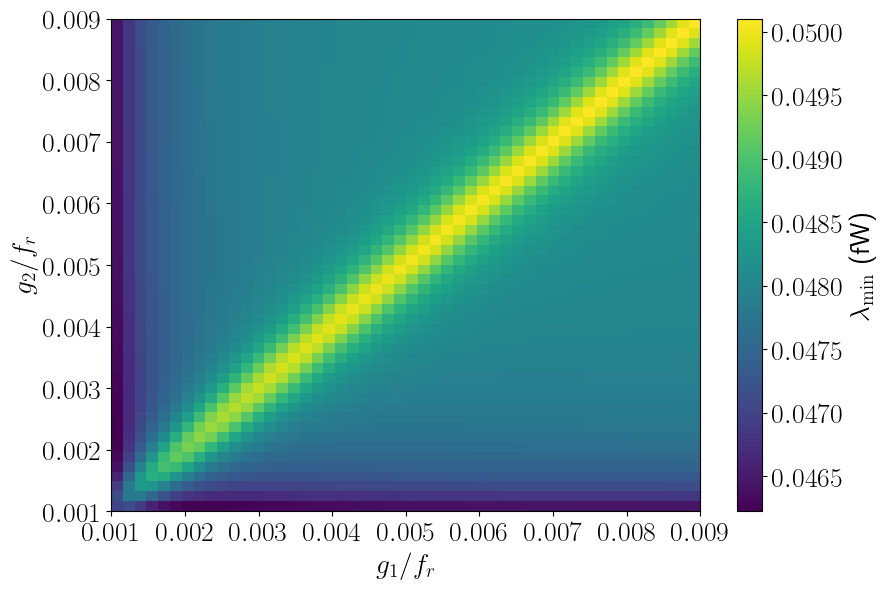

In [29]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda_3,  # negative heat current for display
    extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)




# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

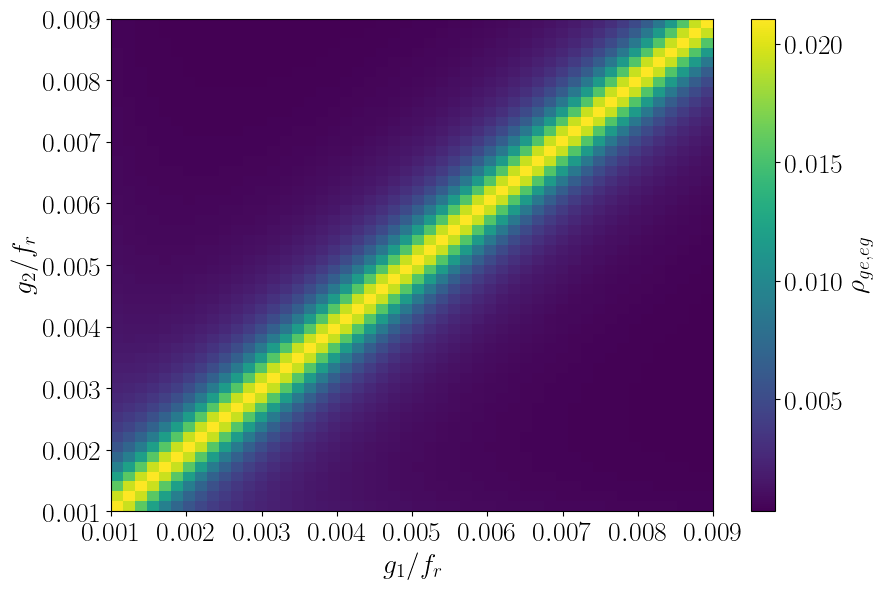

In [30]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Rho_coll_3,  # negative heat current for display
   extent=(g_1.min(), g_1.max(), g_2.min(),g_2.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$g_1/f_r$', fontsize=20)
plt.ylabel(r'$g_2/f_r$', fontsize=20)


cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\rho_{ge, eg}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()